## Initial 'toy' system
I have implemented a modular system in pytorch, with the following:
  
1. **FIRFilter1D**:
   - Implements an arbitrary phase FIR filter using a 1D convolutional layer.
   - The filter taps are learnable parameters.

2. **FIRFilter1DLinearPhaseI**:
   - Implements a linear phase FIR type I filter using 1D convolution.
   - Only allows an odd number of taps and enforces type I symmetry in the filter taps.
   - Taps are learnable parameters (only from the mid-index and up).

3. **GammaToneFilter**:
   - Impulse response of the filter is computed based on specified parameters like center frequency, sampling frequency, and impairment factor
     - !Impairing like this makes no sense just something I did for the toy example.
   - The filter is applied to the input signal using a 1D convolutional layer.

4. **GammaToneFilterbank**:
   - Uses the `GammaToneFilter` module to create individual filters and applies them to the input signal as a filterbank.

5. **NormalModel**:
   - Uses a `GammaToneFilterBank` to process the input with no pre-gain (FIR filter).

6. **ImpairedModel**:
   - Uses a `FIRFilter1D` to apply a learnable gain filter to process which then gets processed by `GammaToneFilterBank`.
   - The gain filter is implemented using `FIRFilter1D`, I have not tried using `FIRFilter1DLinearPhaseI`, although it should work with no issues.

7. **MyModel_v1**:
   - A trainable model composed of a normal hearing model and an impaired hearing model.
   - Uses the `NormalModel` and `ImpairedModel` to process the input and produce outputs for normal and impaired hearing, respectively.

I have tried training a `NormalModel` using SGD with the SI-SDR loss between normal and impaired outputs as the loss function, which was successful. The results are presented under RESULTS below.

![Alt text](../image-11.png)
### Next steps

- [ ] Try to mimic how the DHASP paper implemented the diffrentiable perceptual model.
- [ ] Try to mimic how the DHASP paper implemented the diffrentiable hearing-aid processing model.
- [ ] Introduce a perceptual loss to optimize the NN.


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))
from tools import plot, utils
from tools.nn_modules import *
import numpy as np

import IPython.display as ipd

2.0.1


In [28]:
# helper functions
def plot_gammabank(bank, center_frequencies):
    freq_axes = []
    spec_axes = []
    time_signals = []
    for filter in bank.filters:
        h, f = utils.get_spectrum(filter.impulse_response, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)
        time_signals.append(filter.impulse_response)

    # Plot IR in time-domain and magnitude repsonse
    plot.magspec(
        freq_axes=freq_axes,
        spec_axes=spec_axes,
        title="Magnitude response",
        labels=center_frequencies,
    )
    plot.timeseries(
        time_signals,
        samplerate=samplerate,
        xlim=[0, 0.1],
        title="Impulse responses",
        labels=center_frequencies,
    )


def plot_time_and_spec(signals, samplerate, labels):
    
    freq_axes = []
    spec_axes = []
    for signal in signals:
        h, f = utils.get_spectrum(signal, samplerate=samplerate)
        freq_axes.append(f)
        spec_axes.append(h)

    # Plot IR in time-domain and magnitude repsonse
    plot.timeseries(
        signals, samplerate=samplerate, title="Input-output signals", labels=labels
    )
    plot.magspec(
        freq_axes=freq_axes, spec_axes=spec_axes, title="Spectra", labels=labels
    )


def batch_2_np(batch):
    return batch[0][0].detach().numpy()


def audio_play(signal, samplerate):
    return ipd.display(ipd.Audio(signal, rate=samplerate))  # load a NumPy array

In [29]:

# define parameters
samplerate = 16_000
center_frequencies = [100, 200, 500, 1000, 2000, 4000]
n_batch = 1
n_samples = 16_000
n_channels = 1


Define the filterbank models for impaired and normal hearing listeners

Normal hearing filterbank


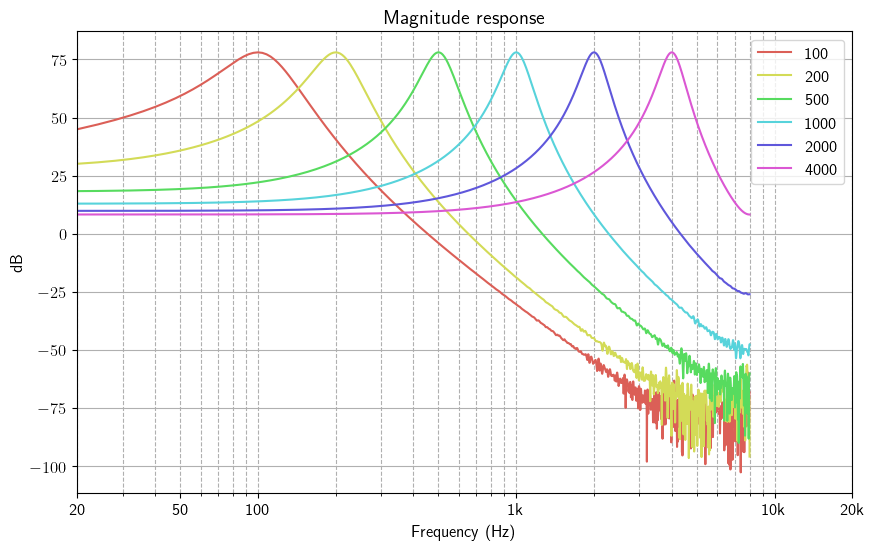

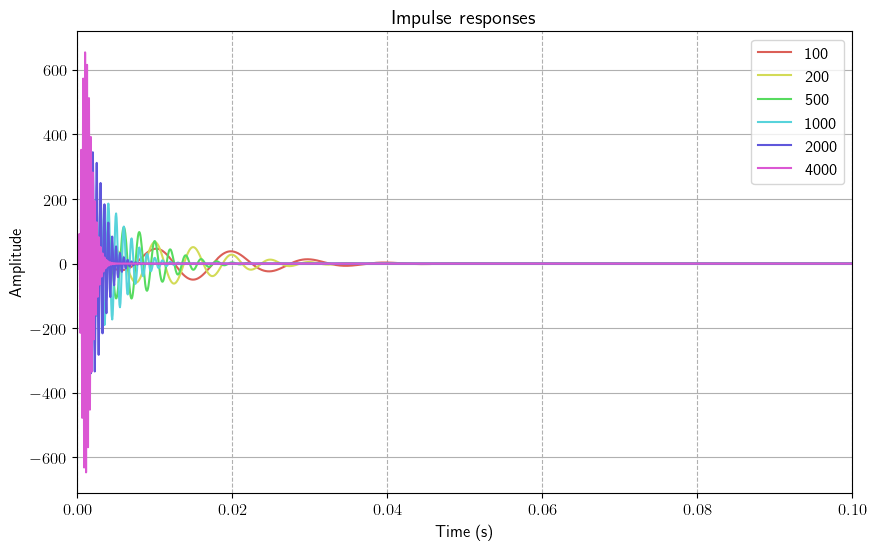

Impaired filterbank


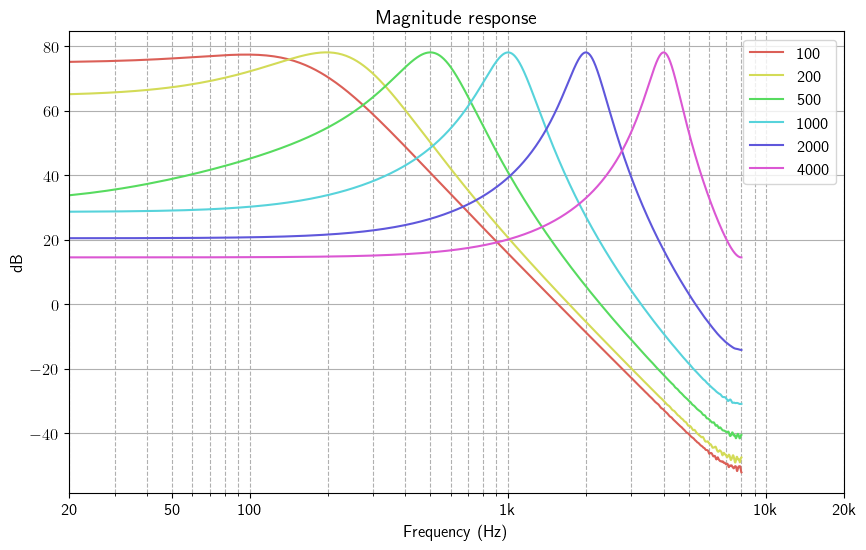

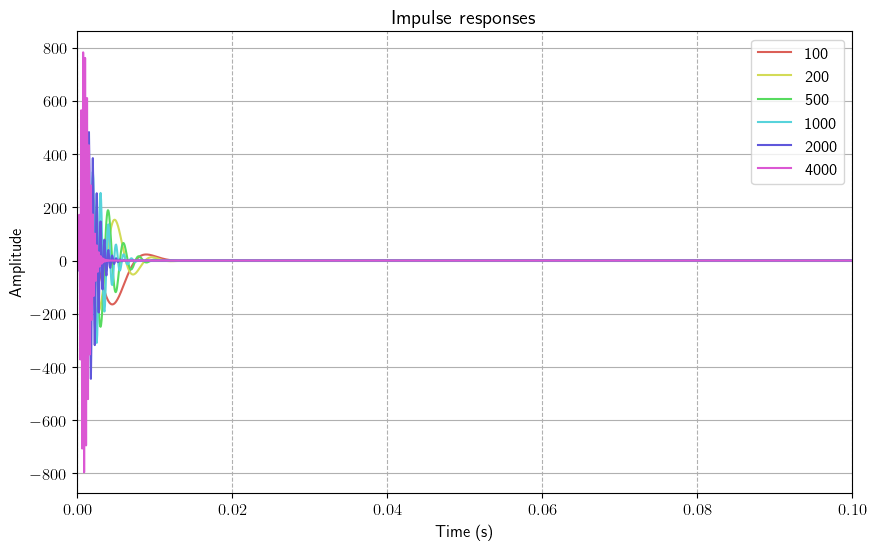

In [30]:
# initiate a normal hearing gammatone filterbank
filterbank_NH = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    impairment_factor=0,
)

# initiate a impaired gammatone filterbank
filterbank_HI = GammaToneFilterbank(
    duration=0.25,
    center_frequencies=center_frequencies,
    fs_hz=samplerate,
    impairment_factor=100,
)


print("Normal hearing filterbank")
plot_gammabank(filterbank_NH,center_frequencies=center_frequencies)
print("Impaired filterbank")
plot_gammabank(filterbank_HI,center_frequencies=center_frequencies)

In [31]:
import torch.optim as optim

# Dummy training data
# Random input data and target labels
n_batch = 1
n_samples = 16_000
n_channels = 1

model = MyModel_v1(
    num_taps=100,
    samplerate=samplerate, 
    center_frequencies=center_frequencies,
    impairment_factor=1000,
)

print(model)

MyModel_v1(
  (normal_model): NormalModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-5): 6 x GammaToneFilter()
      )
    )
  )
  (impaired_model): ImpairedModel(
    (gamma_bank): GammaToneFilterbank(
      (filters): ModuleList(
        (0-5): 6 x GammaToneFilter()
      )
    )
    (gain): FIRFilter1D()
  )
)


input audio


normal hearing  output


impaired output


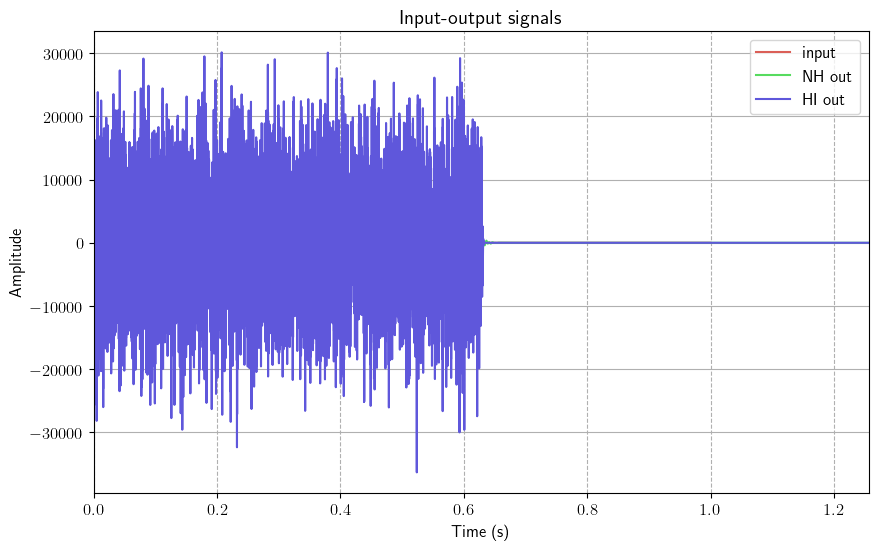

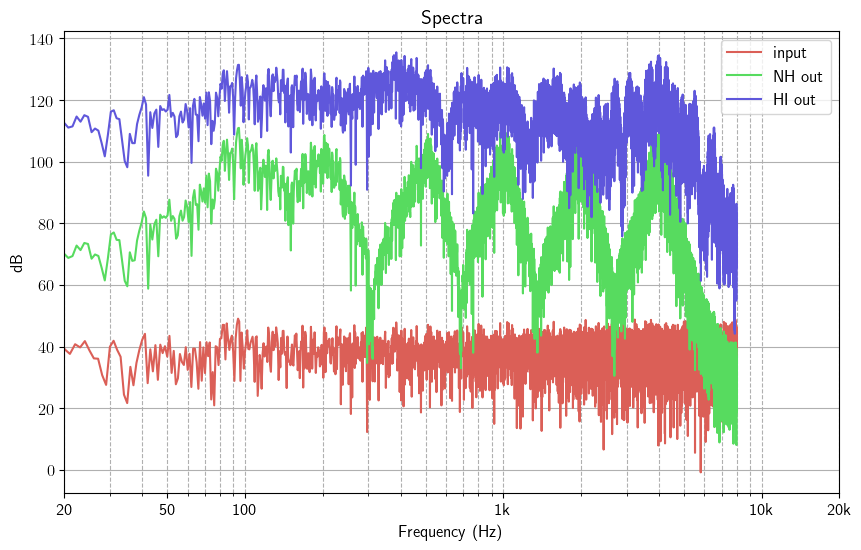

In [32]:
x_noise = torch.randn(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_noise[:,:,10000:] = 0.0  # Input of length 10, all zeros
x_d = torch.zeros(n_batch, n_channels, n_samples)  # Input of length 10, all zeros
x_d[:, :, 0:1000] = 1.0  # Impulse

# choose which signal to excite with
x = x_noise

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)


signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])


input audio


normal hearing  output


impaired output


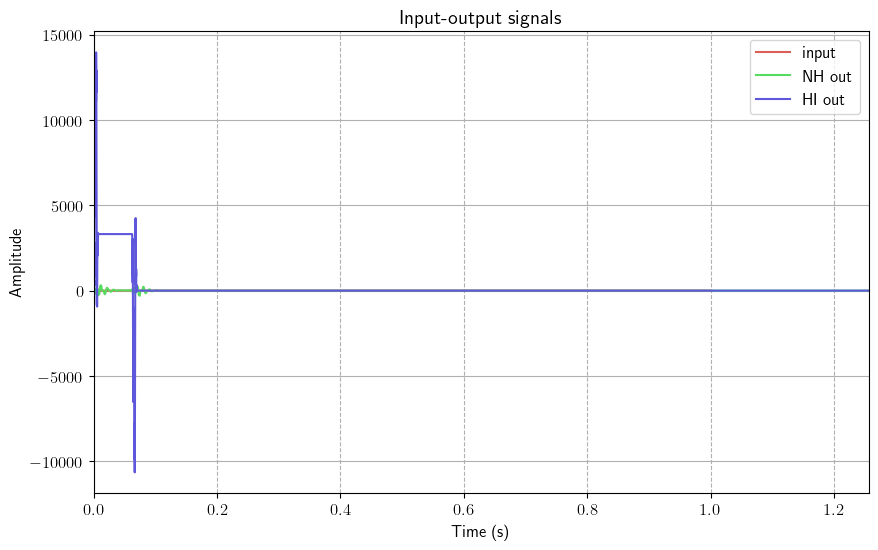

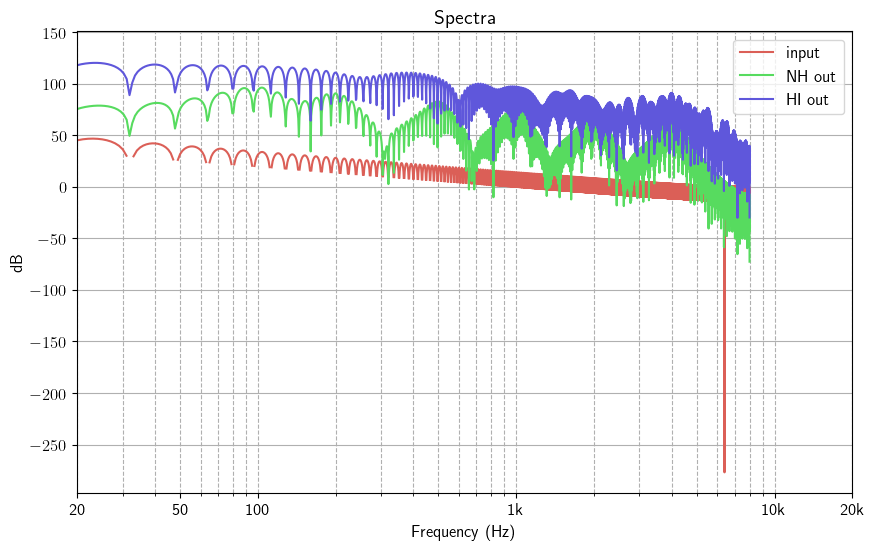

In [33]:
# choose which signal to excite with
x = x_d

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])



In [34]:
import torch.optim as optim
from torchmetrics import ScaleInvariantSignalDistortionRatio

input_data = x_noise # a noise pulse

# Loss function and optimizer
criterion = ScaleInvariantSignalDistortionRatio()
# criterion = nn.
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Dummy training loop
num_epochs = 1200
for epoch in range(num_epochs):
    total_loss = 0.0

    # Forward pass and compute loss
    out_NH, out_HI = model(input_data)
    loss = -criterion(out_HI,out_NH)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")

# Optionally, you can save the trained model
torch.save(model.state_dict(), r'..\models\v1_ntrain1100')

Epoch 1/1200, Loss: 12.617469787597656
Epoch 2/1200, Loss: 12.355043411254883
Epoch 3/1200, Loss: 12.104130744934082
Epoch 4/1200, Loss: 11.863666534423828
Epoch 5/1200, Loss: 11.632729530334473
Epoch 6/1200, Loss: 11.410512924194336
Epoch 7/1200, Loss: 11.196318626403809
Epoch 8/1200, Loss: 10.989526748657227
Epoch 9/1200, Loss: 10.789589881896973
Epoch 10/1200, Loss: 10.596019744873047
Epoch 11/1200, Loss: 10.40838623046875
Epoch 12/1200, Loss: 10.226288795471191
Epoch 13/1200, Loss: 10.049383163452148
Epoch 14/1200, Loss: 9.877351760864258
Epoch 15/1200, Loss: 9.709901809692383
Epoch 16/1200, Loss: 9.54677677154541
Epoch 17/1200, Loss: 9.387733459472656
Epoch 18/1200, Loss: 9.23255443572998
Epoch 19/1200, Loss: 9.081039428710938
Epoch 20/1200, Loss: 8.933003425598145
Epoch 21/1200, Loss: 8.788276672363281
Epoch 22/1200, Loss: 8.646702766418457
Epoch 23/1200, Loss: 8.508134841918945
Epoch 24/1200, Loss: 8.372438430786133
Epoch 25/1200, Loss: 8.239489555358887
Epoch 26/1200, Loss: 8.1

input audio


normal hearing  output


impaired output


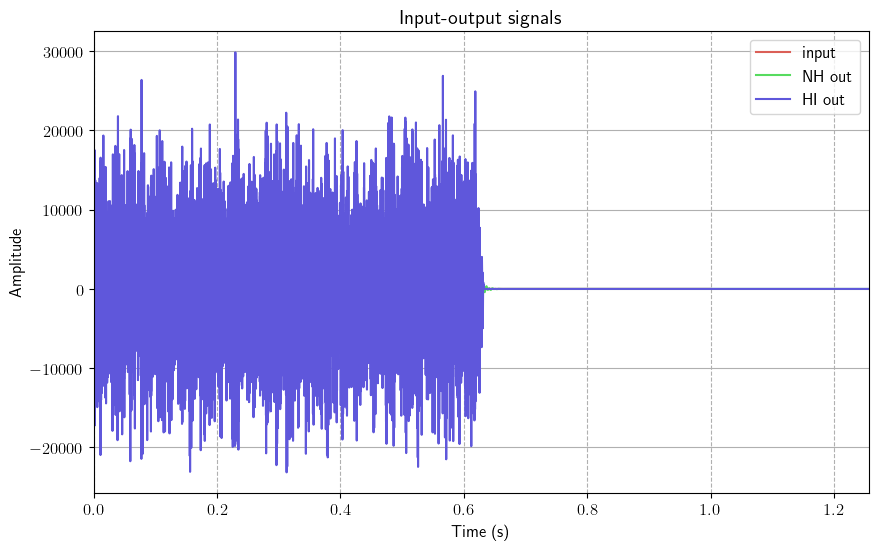

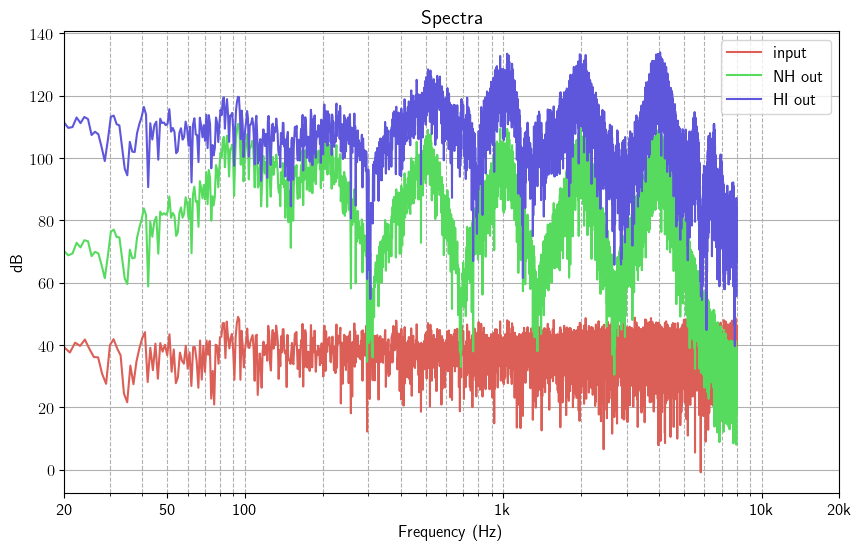

In [35]:
# choose which signal to excite with
x = input_data

# out_NH, out_HI = model(x_noise)
out_NH, out_HI = model(x)

print("input audio")
audio_play(batch_2_np(x),samplerate)
print("normal hearing  output")
audio_play(batch_2_np(out_NH),samplerate)
print("impaired output")
audio_play(batch_2_np(out_HI),samplerate)

signals = [
    batch_2_np(x),
    batch_2_np(out_NH),
    batch_2_np(out_HI),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

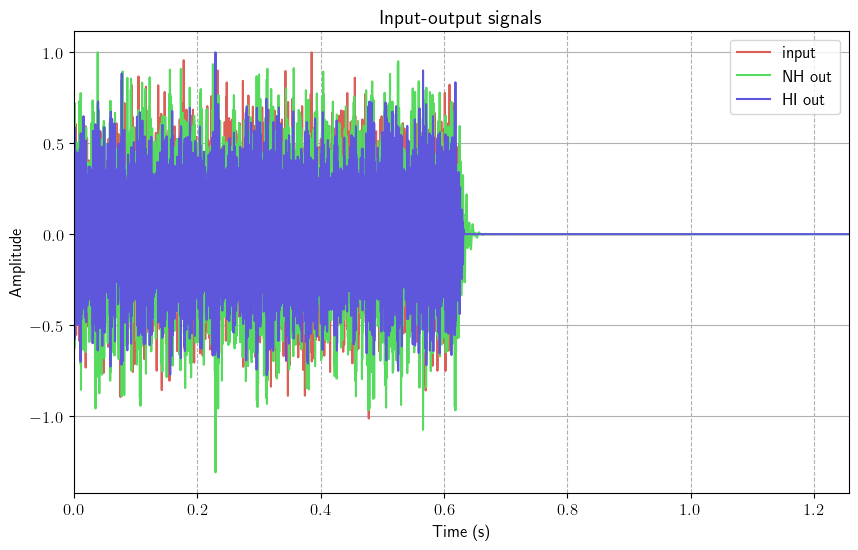

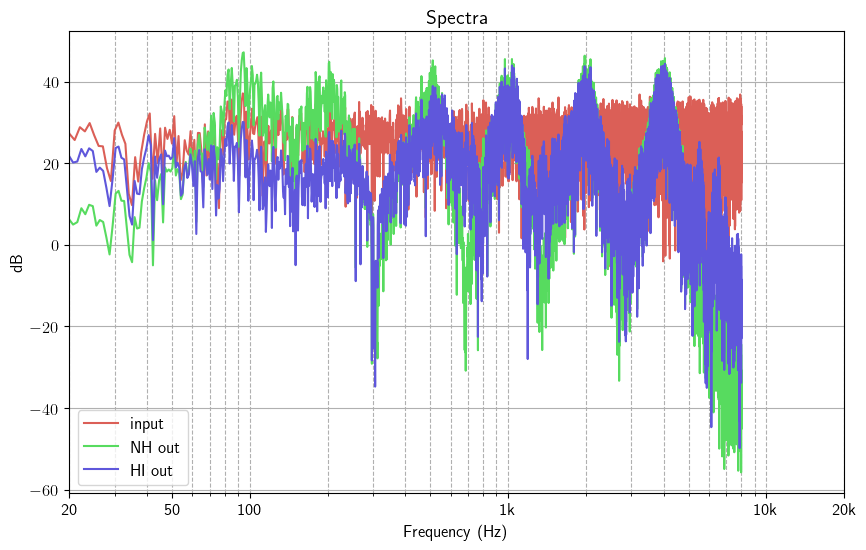

In [38]:
signals = [
    batch_2_np(x) / max(batch_2_np(x)),
    batch_2_np(out_NH) / max(batch_2_np(out_NH)),
    batch_2_np(out_HI) / max(batch_2_np(out_HI)),
]

plot_time_and_spec(signals,samplerate=samplerate,
                   labels= ['input','NH out', 'HI out'])

Inspect predicted filter

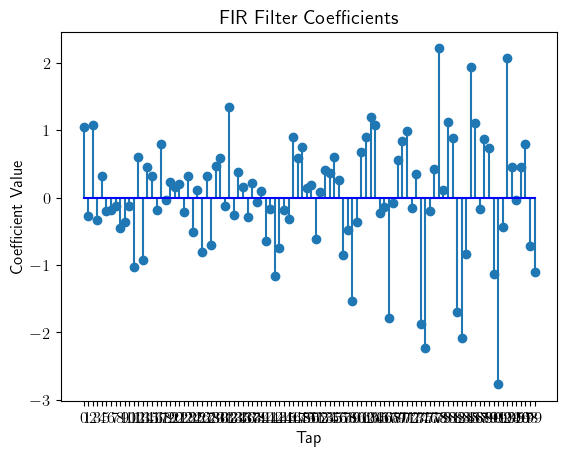

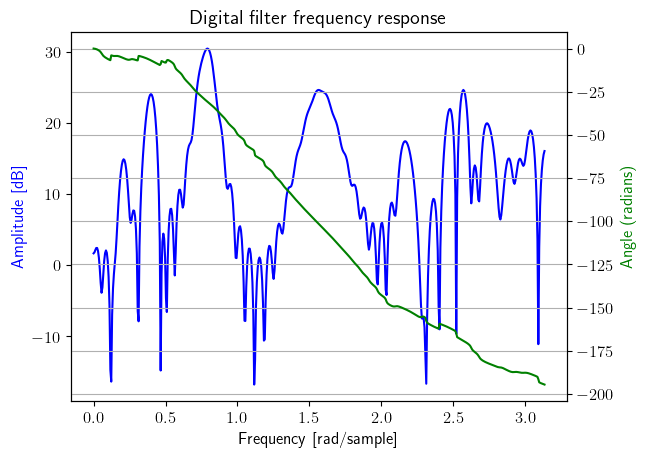

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


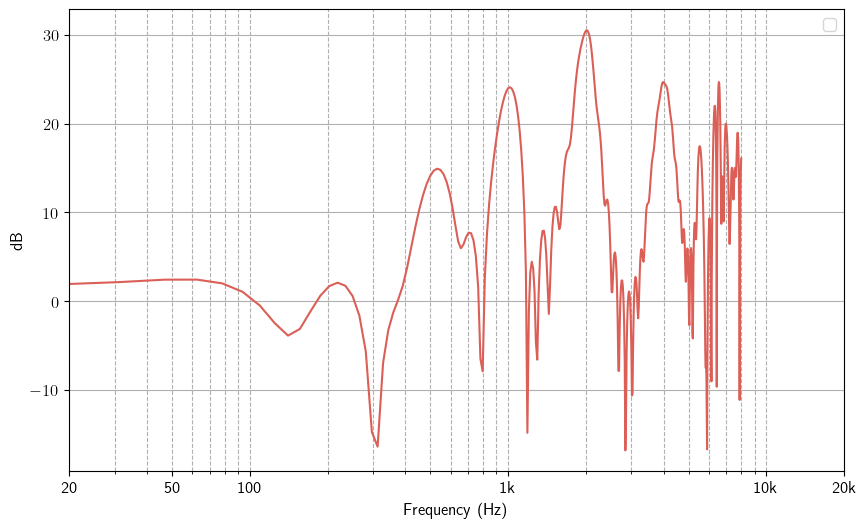

In [36]:
coeffs = model.impaired_model.gain.filter_taps.detach().numpy()
plot.filter_coeffs(coeffs)

from scipy import signal
w, h = signal.freqz(coeffs)
plot.bode_digital(w,h)
plot.magspec([w/(2*pi)*samplerate],[h])